# Calibrating the model

I generated calibration data in R, in code/cleaning/clean_BEA_calibration.R. I compute our exogenous variables as...

$$
\begin{aligned}
\frac{P_j X_{ij}}{P_i Y_i} = \omega_{ij} \tilde{Z}^{\theta- 1} \left(\frac{P_{j}}{Q_i}\right)^{1-\theta} \rightarrow \omega_{ij} = \frac{\bar{X}_{ij}}{\bar{Y}_i}, \text{ expenditure share at base year, normalized to sum to 1} \\
\frac{W_i L_i}{P_i Y_i} = \alpha_i Z^{\epsilon - 1} \left(\frac{W_i}{P_i}\right)^{1-\epsilon} \rightarrow \alpha_i = \frac{\bar{L}_i}{\bar{Y}_i}, \text{ value-added share at base year} \\
\beta_i = \bar{C}_i = \bar{Y}_i - \sum_j \bar{X}_{ji} = \bar{Y}_i - \sum_j \bar{Y}_j (1-\alpha_j) \omega_{ji} = \mathbf{Y}(\mathbf{I} - \text{diag}(1-\alpha)\Omega), \text{ normalized to sum to 1} \\
\bar{L}_i = \alpha_i \bar{Y}_i = \alpha \times (\mathbf{I} - \text{diag}(1-\alpha)\Omega)^{-1} \\
\end{aligned}
$$

By default, I use 2023 as the base year.

In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# I load calibration_data from R
ro.r['load']('../../data/cleaned/structural/calibration_data.RData')
ro.r['load']('../../data/cleaned/code_desc_crosswalk.RData')

# Convert R data frames to pandas DataFrames
with localconverter(ro.default_converter + pandas2ri.converter):
    code_desc_crosswalk = ro.conversion.rpy2py(ro.r['code_desc_crosswalk'])
    Y_list = ro.conversion.rpy2py(ro.r['Y_list'])
    Omega_list = ro.conversion.rpy2py(ro.r['Omega_list'])
    alpha_list = ro.conversion.rpy2py(ro.r['alpha_list'])
    beta_list = ro.conversion.rpy2py(ro.r['beta_list'])
    L_list = ro.conversion.rpy2py(ro.r['L_list'])
    industry_tfp = ro.conversion.rpy2py(ro.r['industry_TFP'])
    elasticity_bycode = ro.conversion.rpy2py(ro.r['elasticity_byCode'])
    cumulative_delta_logOmega = ro.conversion.rpy2py(ro.r['cumulative_delta_logOmega_wide']).to_numpy()
    delta_logOmega_list = ro.conversion.rpy2py(ro.r['delta_logOmega_wide_list'])
    delta_logOmega_predicted10 = ro.conversion.rpy2py(ro.r['delta_logOmega_predicted10']).to_numpy()
    sigma = ro.conversion.rpy2py(ro.r['hh_elasticity']).item()

# generate the covariance matrix of the industry TFP
industry_tfp_annual = industry_tfp.pivot(index='Code', columns='year', values='delta_tfp_1').to_numpy()
industry_tfp_vcov_annual = np.cov(industry_tfp_annual)
industry_tfp_quadrennial = industry_tfp.pivot(index='Code', columns='year', values='delta_tfp_4').to_numpy()
industry_tfp_vcov_quadrennial = np.cov(industry_tfp_quadrennial)

# set off diagonal elements to zero (assume uncorrelated shocks)
industry_tfp_mean_annual = -np.diag(industry_tfp_vcov_annual)/2 # mean 0 in logs isn't mean 0 in levels
industry_tfp_mean_quadrennial = -np.diag(industry_tfp_vcov_quadrennial)/2 # mean 0 in logs isn't mean 0 in levels
industry_tfp_vcov_annual = np.diag(np.diag(industry_tfp_vcov_annual))
industry_tfp_vcov_quadrennial = np.diag(np.diag(industry_tfp_vcov_quadrennial))

# Solving for equilibrium

I solve for two different types of equilibrium: one where labor is not allowed to reallocate across sectors, thereby exogenously fixing $L_i$, and one where labor is fully allowed to reallocate across sectors, equating sectoral wages $W_i = W_j = W$ for all $i,j$. 

## No reallocation

An equilibrium is defined as wages $\{W_i\}_{i=0}^N$, prices $\{P_i\}_{i=0}^N$ and quantities ${Y_i}$ such that...

1) Wages are equal to the marginal product of labor, i.e. $W_i = P_i \times \partial F_i/\partial L_i$ for all $i$. 
2) Prices are equal to marginal cost, i.e. $P_i = MC_i$ for all $i$.
3) All goods markets clear, i.e. $Y_i = \sum_j X_{ij} + C_i$. 

In practice, wages are perfectly pinned down by $Y,P$ and the exogenous variables. So we are solving for prices $P$ and quantities $Y$ that satisfy (2) and (3). We need to write these constraints in terms of exogenous parameters and givens, which we get via the FOC of the firm and household problems. Note that the price of the consumption bundle $\left(\sum_j \beta_j p_j^{1-\sigma}\right)^{\frac{1}{1-\sigma}}$ is normalized to 1. 

$$
\begin{aligned}
MC_i = A_i^{\epsilon_i - 1} (\alpha_i w_i^{1-\epsilon_i}+ (1-\alpha_i)q_i^{1-\epsilon_i})^{\frac{1}{1-\epsilon_i}} \\
X_{ij} = y_i (1-\alpha_i) \omega_{ij} p_i^{\epsilon_i} p_j^{-\theta_i} q_i^{\theta_i-\epsilon_i}Z_i^{\epsilon_i - 1} \tilde{Z}_i^{\theta_i - 1} \\
C_i = C \beta_i p_i^{-\sigma} = wL \beta_i p_i^{-\sigma} 
\end{aligned}
$$

## Full reallocation

Same definition as above, but now labor is endogenously determined, and wages are equalized across sectors. I normalize the wage $W = 1$ to be the numeraire (whereas before the consumption bundle price was normalized to 1), and I redefine aggregate consumption as $C = \sum_i \beta_i p_i^{1-\sigma}$. Other than that things pass as normal.

Note that prices are written using lower cases, since they are defined in relation to the normalization year. 

## Functions

I define functions...

- ```xij(A, Omega, alpha, epsilon, theta, Q, Y, P)```: computes the matrix of intermediate input demand $\{x_{ij}\}$ given exogenous parameters and guesses for prices and quantities.
- ```multisector_constraints_realloc(X, A, Omega, alpha, epsilon, theta, Q, Y, P, C, sigma)```: returns a vector of $P_i - MC_i$ and $Y_i - \sum_j x_{ij} - c_i$ for all $i$ given guesses of prices and quantities in $X$; these need to go to 0 in eqm.
- ```multisector_constraints_no_realloc(X, A, Omega, alpha, epsilon, theta, Q, Y, P, C, sigma)```: same as above, but with labor fixed.
- ```trivial(X)```: pure place-holder, arbitrary function of guess so I can use scipy.optimize.minimize with constraints.
- ```eqm_solver(A, Omega, alpha, epsilon, theta, Q, Y, P, C, sigma, realloc, return_L)```: solves for equilibrium prices and quantities given exogenous parameters and a boolean for whether labor is allowed to reallocate and whether to return labor.
- ```draw_multivariate_normal(cov, num_samples, seed)```: draws from a multivariate normal with a given covariance matrix and seed.
- ```eqm_simulator(A, Omega, alpha, epsilon, theta, Q, Y, P, C, sigma, realloc, return_L, num_samples, seed)```: solves for equilibria given exogenous parameters and TFP shocks drawn from a multivariate normal. Returns GDP and sectoral output.
- ```CD_simulator(A, Omega, alpha, epsilon, theta, Q, Y, P, C, sigma, realloc, return_L, num_samples, seed)```: solves for equilibria but using Cobb-Douglas production functions.

# Elasticity exercises

Exercises examining how my estimates of heterogenous elasticities, across years and across sectors, change the predicted macro effect of sectoral shocks.

## Calibrated shocks

Generate realistic shocks calibrated to TFP data (annual and quadrennial). Compare equilibrium GDP distributions with high/low mean annual elasticity estimates, and heterogenous elasticity estimates, along with Cobb-Douglas benchmark.

In [33]:
# load solver functions
from eqm_solver_functions import *

# set default values (2023)
year = '2023'
Omega = Omega_list[year]
alpha = alpha_list[year]['alpha'].to_numpy()
beta = beta_list[year]['beta'].to_numpy()
L = L_list[year].flatten()

# exogenous elasticities
epsilon = 0.6 # across VA and II; Alireza+ 

# load elasticities
# theta_high = elasticity_bycode['p75_theta'].to_numpy()
# theta_low = elasticity_bycode['p25_theta'].to_numpy()
theta_het = elasticity_bycode['theta'].to_numpy()
theta_unif = elasticity_bycode['theta'].mean() * np.ones(len(theta_het))

# set initial guesses
Y_norm = beta@np.linalg.inv(np.eye(len(alpha)) - np.diag(1 - alpha)@Omega)
P_norm = np.ones(len(alpha))

# get Domar weights; used for Cobb-Douglas comparison
domar_weights = beta@np.linalg.inv(np.eye(len(alpha)) - np.diag(1 - alpha)@Omega)

# draw shocks
annual_shocks = draw_multivariate_normal(industry_tfp_mean_annual, industry_tfp_vcov_annual, 1000, seed=1)
quad_shocks = draw_multivariate_normal(industry_tfp_mean_quadrennial, industry_tfp_vcov_quadrennial, 1000, seed=1) # magnified shocks = business-cycle shocks

# simulate GDP and sectoral output distributions
gdp_dist_CD_annual = CD_simulator(domar_weights, annual_shocks)
# gdp_dist_high_annual, sectoral_output_high_annual = eqm_simulator(beta, Omega, alpha, epsilon, theta_high, sigma, L, P_norm, Y_norm, annual_shocks)
# gdp_dist_low_annual, sectoral_output_low_annual = eqm_simulator(beta, Omega, alpha, epsilon, theta_low, sigma, L, P_norm, Y_norm, annual_shocks)
gdp_dist_CD_quad = CD_simulator(domar_weights, quad_shocks)
# gdp_dist_high_quad, sectoral_output_high_quad = eqm_simulator(beta, Omega, alpha, epsilon, theta_high, sigma, L, P_norm, Y_norm, quad_shocks)
# gdp_dist_low_quad, sectoral_output_low_quad = eqm_simulator(beta, Omega, alpha, epsilon, theta_low, sigma, L, P_norm, Y_norm, quad_shocks)
gdp_dist_unif_annual, sectoral_output_unif_annual = eqm_simulator(beta, Omega, alpha, epsilon, theta_unif, sigma, L, P_norm, Y_norm, annual_shocks)
gdp_dist_het_annual, sectoral_output_het_annual = eqm_simulator(beta, Omega, alpha, epsilon, theta_het, sigma, L, P_norm, Y_norm, annual_shocks)
gdp_dist_unif_quad, sectoral_output_unif_quad = eqm_simulator(beta, Omega, alpha, epsilon, theta_unif, sigma, L, P_norm, Y_norm, quad_shocks)
gdp_dist_het_quad, sectoral_output_het_quad = eqm_simulator(beta, Omega, alpha, epsilon, theta_het, sigma, L, P_norm, Y_norm, quad_shocks)

# save results
gdp_dist = pd.DataFrame({'gdp_dist_CD_annual': gdp_dist_CD_annual, 'gdp_dist_CD_quad': gdp_dist_CD_quad, 'gdp_dist_unif_annual': gdp_dist_unif_annual, 'gdp_dist_het_annual': gdp_dist_het_annual, 'gdp_dist_unif_quad': gdp_dist_unif_quad, 'gdp_dist_het_quad': gdp_dist_het_quad})
gdp_dist.to_csv("../../data/cleaned/structural/simulated_gdp.csv", index=False)
df_builder = lambda x: pd.DataFrame(x, columns=elasticity_bycode['Code'])
unif_quad_df = df_builder(sectoral_output_unif_quad).to_csv('../../data/cleaned/structural/sectoral_output_unif_quad.csv', index=False)
het_quad_df = df_builder(sectoral_output_het_quad).to_csv('../../data/cleaned/structural/sectoral_output_het_quad.csv', index=False)

Convergence!
Remaining samples:  999
Convergence!
Remaining samples:  998
Convergence!
Remaining samples:  997
Convergence!
Remaining samples:  996
Convergence!
Remaining samples:  995
Convergence!
Remaining samples:  994
Convergence!
Remaining samples:  993
Convergence!
Remaining samples:  992
Convergence!
Remaining samples:  991
Convergence!
Remaining samples:  990
Convergence!
Remaining samples:  989
Convergence!
Remaining samples:  988
Convergence!
Remaining samples:  987
Convergence!
Remaining samples:  986
Convergence!
Remaining samples:  985
Convergence!
Remaining samples:  984
Convergence!
Remaining samples:  983
Convergence!
Remaining samples:  982
Convergence!
Remaining samples:  981
Convergence!
Remaining samples:  980
Convergence!
Remaining samples:  979
Convergence!
Remaining samples:  978
Convergence!
Remaining samples:  977
Convergence!
Remaining samples:  976
Convergence!
Remaining samples:  975
Convergence!
Remaining samples:  974
Convergence!
Remaining samples:  973
C

In [34]:
from scipy.stats import skew
import pandas as pd
import numpy as np

# import gdp_dist
gdp_dist = pd.read_csv("../../data/cleaned/structural/simulated_gdp.csv")
gdp_dist = gdp_dist.dropna() # remove rows with nans
gdp_dist_CD_annual = gdp_dist['gdp_dist_CD_annual']
gdp_dist_CD_quad = gdp_dist['gdp_dist_CD_quad']
gdp_dist_unif_annual = gdp_dist['gdp_dist_unif_annual']
gdp_dist_het_annual = gdp_dist['gdp_dist_het_annual']
gdp_dist_unif_quad = gdp_dist['gdp_dist_unif_quad']
gdp_dist_het_quad = gdp_dist['gdp_dist_het_quad']

# Calculate statistics for annual shocks
annual_stats = {
    'mean': [np.mean(np.log(gdp_dist_CD_annual)), np.mean(np.log(gdp_dist_unif_annual)), np.mean(np.log(gdp_dist_het_annual))],
    'sd': [np.std(np.log(gdp_dist_CD_annual)), np.std(np.log(gdp_dist_unif_annual)), np.std(np.log(gdp_dist_het_annual))],
    'skew': [skew(np.log(gdp_dist_CD_annual)), skew(np.log(gdp_dist_unif_annual)), skew(np.log(gdp_dist_het_annual))]
}

# Calculate statistics for quad shocks
quad_stats = {
    'mean': [np.mean(np.log(gdp_dist_CD_quad)), np.mean(np.log(gdp_dist_unif_quad)), np.mean(np.log(gdp_dist_het_quad))],
    'sd': [np.std(np.log(gdp_dist_CD_quad)), np.std(np.log(gdp_dist_unif_quad)), np.std(np.log(gdp_dist_het_quad))],
    'skew': [skew(np.log(gdp_dist_CD_quad)), skew(np.log(gdp_dist_unif_quad)), skew(np.log(gdp_dist_het_quad))]
}

# Create a DataFrame for the results

results_baseline = pd.DataFrame({
    'Cobb-Douglas': [annual_stats['mean'][0], annual_stats['sd'][0], annual_stats['skew'][0]],
    'Uniform': [annual_stats['mean'][1], annual_stats['sd'][1], annual_stats['skew'][1]],
    'Sector-Specific': [annual_stats['mean'][2], annual_stats['sd'][2], annual_stats['skew'][2]]
}, index=['Mean', 'SD', 'Skewness'])

results_quad = pd.DataFrame({
    'Cobb-Douglas': [quad_stats['mean'][0], quad_stats['sd'][0], quad_stats['skew'][0]],
    'Uniform': [quad_stats['mean'][1], quad_stats['sd'][1], quad_stats['skew'][1]],
    'Sector-Specific': [quad_stats['mean'][2], quad_stats['sd'][2], quad_stats['skew'][2]],
}, index=['Mean', 'SD', 'Skewness'])

# save table to latex 
results_baseline = results_baseline.transpose()
results_quad = results_quad.transpose()
results = pd.concat([results_baseline, results_quad], axis=1)
results_tab = results.to_latex(float_format = '%.3f')
custom_header = r"""
\begin{tabular}{lcccccc}
\toprule
& \multicolumn{3}{c}{Annual shocks} & \multicolumn{3}{c}{Quadrennial shocks} \\
"""
results_tab = results_tab.replace(r"\begin{tabular}{lrrrrrr}", custom_header)
with open("../../tables/shock_simulation_results_combined.tex", "w") as f:
    f.write(results_tab)

## Sector-varying elasticity exercises

Generate severe shocks to individual sectors that cut their output by 50%. Compare resulting equilibrium GDP with sector-varying elasticities versus the corresponding mean imposed uniformly.

In [27]:
# load solver functions
from eqm_solver_functions import *

# set default values (2023)
year = '2023'
Omega = Omega_list[year]
alpha = alpha_list[year]['alpha'].to_numpy()
beta = beta_list[year]['beta'].to_numpy()
L = L_list[year].flatten()

# exogenous elasticities
epsilon = 0.6 # across VA and II; Alireza+ 

# load elasticities
theta_het = elasticity_bycode['theta'].to_numpy()
theta_mean = elasticity_bycode['theta'].mean() * np.ones(len(alpha))

Y_norm = beta@np.linalg.inv(np.eye(len(alpha)) - np.diag(1 - alpha)@Omega)
P_norm = np.ones(len(alpha))

# take SD across all observations in industry_tfp_annual
outlier = -np.log(2)
extreme_shocks = []
for i in range(len(alpha)): 
    shock = np.zeros(len(alpha))
    shock[i] = outlier
    extreme_shocks.append(shock)

gdp_dist_het_extreme, sectoral_output_het_extreme = eqm_simulator(beta, Omega, alpha, epsilon, theta_het, sigma, L, P_norm, Y_norm, extreme_shocks)
gdp_dist_mean_extreme, sectoral_output_mean_extreme = eqm_simulator(beta, Omega, alpha, epsilon, theta_mean, sigma, L, P_norm, Y_norm, extreme_shocks)
gdp_diff = gdp_dist_het_extreme - gdp_dist_mean_extreme 

# dataframe with industry labels
gdp_diff = pd.DataFrame({'Het.': gdp_dist_het_extreme - 1, 'Uniform': gdp_dist_mean_extreme - 1, 'Difference': gdp_diff, 'Code': elasticity_bycode['Code']}) # the minus 1 is reference to no shock GDP = 1
gdp_diff = gdp_diff.merge(code_desc_crosswalk, on='Code')
# make table of industry description and smallest differences
diff_tab = gdp_diff.sort_values(by='Difference', ascending=False) 
diff_tab = diff_tab[['Industry Description', 'Het.', 'Uniform', 'Difference']]
diff_tab_big = diff_tab.head(3)
diff_tab = gdp_diff.sort_values(by='Difference', ascending=True)
diff_tab = diff_tab[['Industry Description', 'Het.', 'Uniform', 'Difference']]
diff_tab_small = diff_tab.head(3)
diff_tab = pd.concat([diff_tab_small, diff_tab_big])
# rename columns
diff_tab.columns = ['Industry Description', 'Sector-Specific', 'Uniform', 'Difference']
diff_tab['Industry Description'] = diff_tab['Industry Description'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x) # abridge industry descriptions at 50 characters

# write table
latex_table = diff_tab.to_latex(index=False, float_format="%.3f", column_format='lccc')
lines = latex_table.splitlines()
lines.insert(4, r'\midrule')
lines.insert(5, r'\multicolumn{2}{l}{\textbf{Larger GDP loss}} \\')
lines.insert(6, r'\midrule')
# add a blank line
lines.insert(10, r'\midrule')
lines.insert(11, r'\multicolumn{2}{l}{\textbf{Smaller GDP loss}} \\')
lines.insert(12, r'\midrule')
latex_table = '\n'.join(lines)

with open("../../tables/industry_diff_extreme.tex", "w") as f:
    f.write(latex_table)

Convergence!
Remaining samples:  65
Convergence!
Remaining samples:  64
Convergence!
Remaining samples:  63
Convergence!
Remaining samples:  62
Convergence!
Remaining samples:  61
Convergence!
Remaining samples:  60
Convergence!
Remaining samples:  59
Convergence!
Remaining samples:  58
Convergence!
Remaining samples:  57
Convergence!
Remaining samples:  56
Convergence!
Remaining samples:  55
Convergence!
Remaining samples:  54
Convergence!
Remaining samples:  53
Convergence!
Remaining samples:  52
Convergence!
Remaining samples:  51
Convergence!
Remaining samples:  50
Convergence!
Remaining samples:  49
Convergence!
Remaining samples:  48
Convergence!
Remaining samples:  47
Convergence!
Remaining samples:  46
Convergence!
Remaining samples:  45
Convergence!
Remaining samples:  44
Convergence!
Remaining samples:  43
Convergence!
Remaining samples:  42
Convergence!
Remaining samples:  41
Convergence!
Remaining samples:  40
Convergence!
Remaining samples:  39
Convergence!
Remaining sampl

# Share parameter exercises

## Share parameters and changes in sectoral output

Using the cumulative sum of share parameter shifts estimated empirically, simulate counterfactual Omega corresponding to 2023 (assuming no other exogenous parameters change). Estimate response of sectoral output, with and without labor reallocation.

In [ ]:
# load solver functions
from eqm_solver_functions import *

# set initial values for 2023
year = '2023'
Omega = Omega_list[year]
alpha = alpha_list[year]['alpha'].to_numpy()
beta = beta_list[year]['beta'].to_numpy()
L = L_list[year].flatten()

# exogenous elasticities
epsilon = 0.6 # across VA and II; Alireza+ 

# load elasticities
theta = elasticity_bycode['theta'].to_numpy()
theta_mean = elasticity_bycode['theta'].mean() * np.ones(len(alpha))

# get counterfactual Omega
Omega_counterfactual = Omega.copy()
Omega_counterfactual = Omega_counterfactual * np.exp(-cumulative_delta_logOmega)
Omega_counterfactual = Omega_counterfactual / Omega_counterfactual.sum(axis=1)[:, np.newaxis] # normalize rows to sum to 1

Y_norm = beta@np.linalg.inv(np.eye(len(alpha)) - np.diag(1 - alpha)@Omega)
P_norm = np.ones(len(alpha))

# solve for counterfactual output with reallocation
C_1, Y_1 = eqm_solver(np.ones(len(alpha)), beta, Omega, alpha, epsilon, theta, sigma, L, P_norm, Y_norm, reallocate=True)
C_0, Y_0 = eqm_solver(np.ones(len(alpha)), beta, Omega_counterfactual, alpha, epsilon, theta, sigma, L, P_norm, Y_norm, reallocate=True)
counterfactual_output_realloc = pd.DataFrame({'Code': elasticity_bycode['Code'], 'Y_1': Y_1, 'Y_0': Y_0, 'log_change': np.log(Y_1) - np.log(Y_0)})
counterfactual_output_realloc = counterfactual_output_realloc.sort_values(by='log_change', ascending=False)

# select 3 largest increases in output, without and with reallocation
counterfactual_output_combined_table = counterfactual_output_realloc.head(3)
counterfactual_output_combined_table = counterfactual_output_combined_table.merge(code_desc_crosswalk, on='Code')
counterfactual_output_combined_table = counterfactual_output_combined_table[['Industry Description', 'log_change']]
# abridge industry descriptions at 50 characters
# add ellipsis if longer
counterfactual_output_combined_table['Industry Description'] = counterfactual_output_combined_table['Industry Description'].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)
counterfactual_output_combined_table = counterfactual_output_combined_table.rename(columns={'log_change': 'Output Growth, 1997-2023'})

latex_table = counterfactual_output_combined_table.to_latex(index=False, float_format="%.3f")

with open("../../tables/cumulative_counterfactual_output_change.tex", "w") as f:
    f.write(latex_table)

Convergence!
Convergence!


Use year-to-year changes in share parameters, predict the effect on sectoral output. Save results to compare to actual data.

In [ ]:
# load solver functions
from eqm_solver_functions import *

# exogenous elasticities
epsilon = 0.6 # across VA and II; Alireza+ 

# load elasticities
theta = elasticity_bycode['theta'].to_numpy()

# initial guesses
Y_norm = beta@np.linalg.inv(np.eye(len(alpha)) - np.diag(1 - alpha)@Omega)
P_norm = np.ones(len(alpha))

# set initial Omega
temp_Omega = Omega.copy()

# initialize counterfactual sectoral output
counterfactual_output_change = pd.DataFrame({'Code': elasticity_bycode['Code']})

# set starting point 
C_previous, Y_previous = eqm_solver(np.ones(len(alpha)), beta, Omega, alpha, epsilon, theta, sigma, L, P_norm, Y_norm) 

for i in range(1997, 2023):
    # t = 0 calibration
    temp_Omega = Omega_list[str(i)]
    temp_alpha = alpha_list[str(i)]['alpha'].to_numpy()
    temp_beta = beta_list[str(i)]['beta'].to_numpy()
    temp_L = L_list[str(i)].flatten()

    # t = 1 change
    Omega_counterfactual = temp_Omega.copy()
    delta_Omega = np.exp(delta_logOmega_list[str(i+1)]).to_numpy()
    Omega_counterfactual = Omega_counterfactual * delta_Omega
    Omega_counterfactual = Omega_counterfactual / Omega_counterfactual.sum(axis=1)[:, np.newaxis] # normalize to 1

    # corresponding beta_counterfactual, L_counterfactual
    Y = Y_list[str(i)]
    beta_counterfactual = Y@(np.eye(len(alpha)) - np.diag(alpha))@Omega_counterfactual
    beta_counterfactual = beta_counterfactual / beta_counterfactual.sum()
    L_counterfactual = alpha*(beta_counterfactual.T@np.linalg.inv(np.eye(len(alpha)) - (np.diag(1 - alpha)@Omega_counterfactual)))

    # solve for C_0, Y_0, C_1, Y_1
    C_0, Y_0 = eqm_solver(np.ones(len(alpha)), temp_beta, temp_Omega, temp_alpha, epsilon, theta, sigma, temp_L, P_norm, Y_norm)
    C_1, Y_1 = eqm_solver(np.ones(len(alpha)), temp_beta, Omega_counterfactual, temp_alpha, epsilon, theta, sigma, temp_L, P_norm, Y_norm)
    counterfactual_output_change[str(i+1)] = np.log(Y_1) - np.log(Y_0)

counterfactual_output_change.to_csv("../../data/cleaned/structural/counterfactual_output_change_byyear.csv", index=False)

## Effect on sectoral shocks 

Using the counterfactual $\tilde{\Omega}_{2023}$ corresponding to share parameter shifts between 1997-2023, estimate the effect of severe shocks to individual sectors on GDP. Note that I list log-deviations from non-shocked GDP; since log output at the original point is 0, this doesn't matter, but it does for the counterfactual Omega, since that implies a different non-shocked GDP.

In [3]:
from eqm_solver_functions import *

# set initial values for 1997
year = '2023'
Omega = Omega_list[year]
alpha = alpha_list[year]['alpha'].to_numpy()
beta = beta_list[year]['beta'].to_numpy()
L = L_list[year].flatten()

# exogenous elasticities
epsilon = 0.6 # across VA and II; Alireza+ 

# load elasticities
theta = elasticity_bycode['theta'].to_numpy()

# get counterfactual Omega (1997)
Omega_counterfactual = Omega.copy()
Omega_counterfactual = Omega_counterfactual * np.exp(-cumulative_delta_logOmega)
Omega_counterfactual = Omega_counterfactual / Omega_counterfactual.sum(axis=1)[:, np.newaxis] # normalize rows to sum to 1

# set initial guesses
Y_norm = beta@np.linalg.inv(np.eye(len(alpha)) - np.diag(1 - alpha)@Omega)
P_norm = np.ones(len(alpha))

# recover reallocated L
L_counterfactual = eqm_solver(np.ones(len(alpha)), beta, Omega_counterfactual, alpha, epsilon, theta, sigma, L, P_norm, Y_norm, reallocate=True, return_L=True)

# extreme shocks
outlier = -np.log(2) # cut output by 50%
extreme_shocks = []
for i in range(len(alpha)): 
    shock = np.zeros(len(alpha))
    shock[i] = outlier
    extreme_shocks.append(shock)

gdp_noshock_1, sectoral_output_noshock_1 = eqm_solver(np.ones(len(alpha)), beta, Omega, alpha, epsilon, theta, sigma, L, P_norm, Y_norm)
gdp_dist_1, sectoral_output_1 = eqm_simulator(beta, Omega, alpha, epsilon, theta, sigma, L, P_norm, Y_norm, extreme_shocks)
gdp_dist_1 = gdp_dist_1 - gdp_noshock_1 # dataframe difference in gdp, shock - no shock
gdp_noshock_0, sectoral_output_noshock_0 = eqm_solver(np.ones(len(alpha)), beta, Omega_counterfactual, alpha, epsilon, theta, sigma, L_counterfactual, P_norm, Y_norm)
gdp_dist_0, sectoral_output_0 = eqm_simulator(beta, Omega_counterfactual, alpha, epsilon, theta, sigma, L_counterfactual, P_norm, Y_norm, extreme_shocks)
gdp_dist_0 = gdp_dist_0 - gdp_noshock_0 # dataframe difference in gdp, shock - no shock

gdp_diff = gdp_dist_1 - gdp_dist_0 # difference 2023-1997


gdp_diff = pd.DataFrame({'2023':gdp_dist_1, '1997':gdp_dist_0, 'Difference': gdp_diff, 'Code': elasticity_bycode['Code']}) # dataframe with industry labels
gdp_diff = gdp_diff.merge(code_desc_crosswalk, on='Code')
gdp_diff = gdp_diff[['Industry Description', '2023', '1997', 'Difference']] 
gdp_diff['Industry Description'] = gdp_diff['Industry Description'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x) # abridge industry descriptions at 50 characters

diff_tab_decrease = gdp_diff.sort_values(by='Difference', ascending=False).head(3)
diff_tab_increase = gdp_diff.sort_values(by='Difference', ascending=True).head(3)
diff_tab = pd.concat([diff_tab_increase, diff_tab_decrease]) # stack dataframes
diff_tab.columns = ['Industry Description', '${\\Omega}_{2023}$', '$\\tilde{\\Omega}_{1997}$', 'Difference']

# write table
latex_table = diff_tab.to_latex(index=False, float_format="%.3f", column_format='lccc')
lines = latex_table.splitlines()
lines.insert(4, r'\midrule')
lines.insert(5, r'\multicolumn{2}{l}{\textbf{Larger GDP loss}} \\')
lines.insert(6, r'\midrule')
# add a blank line
lines.insert(10, r'\midrule')
lines.insert(11, r'\multicolumn{2}{l}{\textbf{Smaller GDP loss}} \\')
lines.insert(12, r'\midrule')
latex_table = '\n'.join(lines)

with open("../../tables/ind_sector_shock_1997_2023.tex", "w") as f:
    f.write(latex_table)

Convergence!
Convergence!
Convergence!
Remaining samples:  65
Convergence!
Remaining samples:  64
Convergence!
Remaining samples:  63
Convergence!
Remaining samples:  62
Convergence!
Remaining samples:  61
Convergence!
Remaining samples:  60
Convergence!
Remaining samples:  59
Convergence!
Remaining samples:  58
Convergence!
Remaining samples:  57
Convergence!
Remaining samples:  56
Convergence!
Remaining samples:  55
Convergence!
Remaining samples:  54
Convergence!
Remaining samples:  53
Convergence!
Remaining samples:  52
Convergence!
Remaining samples:  51
Convergence!
Remaining samples:  50
Convergence!
Remaining samples:  49
Convergence!
Remaining samples:  48
Convergence!
Remaining samples:  47
Convergence!
Remaining samples:  46
Convergence!
Remaining samples:  45
Convergence!
Remaining samples:  44
Convergence!
Remaining samples:  43
Convergence!
Remaining samples:  42
Convergence!
Remaining samples:  41
Convergence!
Remaining samples:  40
Convergence!
Remaining samples:  39
Co

Now I do the same exercise, but the baseline year is 2023, and I generate $\tilde{\Omega}_{2033}$ to predict future share parameters based on linear trends (i.e. add the share parameter shifts from 2013-2023).

In [4]:
# set initial values for 2023
year = '2023'
Omega = Omega_list[year]
alpha = alpha_list[year]['alpha'].to_numpy()
beta = beta_list[year]['beta'].to_numpy()
L = L_list[year].flatten()

# exogenous elasticities
epsilon = 0.6 # across VA and II; Alireza+ 

# load elasticities
theta = elasticity_bycode['theta'].to_numpy()

# get predicted Omega
Omega_predicted = Omega.copy()
Omega_predicted = Omega_predicted * np.exp(delta_logOmega_predicted10)
Omega_predicted = Omega_predicted / Omega_predicted.sum(axis=1)[:, np.newaxis] # normalize rows to sum to 1

# set initial guesses
Y_norm = beta@np.linalg.inv(np.eye(len(alpha)) - np.diag(1 - alpha)@Omega)
P_norm = np.ones(len(alpha))

# recover reallocated L
L_counterfactual = eqm_solver(np.ones(len(alpha)), beta, Omega_predicted, alpha, epsilon, theta, sigma, L, P_norm, Y_norm, reallocate=True, return_L=True)

# extreme shocks
outlier = -np.log(2) # cut output by 75%
extreme_shocks = []
for i in range(len(alpha)): 
    shock = np.zeros(len(alpha))
    shock[i] = outlier
    extreme_shocks.append(shock)

gdp_noshock_0, sectoral_output_noshock_0 = eqm_solver(np.ones(len(alpha)), beta, Omega, alpha, epsilon, theta, sigma, L, P_norm, Y_norm)
gdp_dist_0, sectoral_output_0 = eqm_simulator(beta, Omega, alpha, epsilon, theta, sigma, L, P_norm, Y_norm, extreme_shocks)
gdp_dist_0 = gdp_dist_0 - gdp_noshock_0 # dataframe difference in gdp, shock - no shock
gdp_noshock_1, sectoral_output_noshock_1 = eqm_solver(np.ones(len(alpha)), beta, Omega_predicted, alpha, epsilon, theta, sigma, L_counterfactual, P_norm, Y_norm)
gdp_dist_1, sectoral_output_1= eqm_simulator(beta, Omega_predicted, alpha, epsilon, theta, sigma, L_counterfactual, P_norm, Y_norm, extreme_shocks)
gdp_dist_1 = gdp_dist_1 - gdp_noshock_1 # dataframe difference in gdp, shock - no shock


gdp_diff = gdp_dist_1 - gdp_dist_0 # magnitude difference 

gdp_diff = pd.DataFrame({'2033':gdp_dist_1, '2023':gdp_dist_0, 'Difference': gdp_diff, 'Code': elasticity_bycode['Code']}) # dataframe with industry labels
gdp_diff = gdp_diff.merge(code_desc_crosswalk, on='Code')
gdp_diff = gdp_diff[['Industry Description', '2033', '2023', 'Difference']] 
gdp_diff['Industry Description'] = gdp_diff['Industry Description'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x) # abridge industry descriptions at 50 characters

diff_tab_decrease = gdp_diff.sort_values(by='Difference', ascending=False).head(3)
diff_tab_increase = gdp_diff.sort_values(by='Difference', ascending=True).head(3)
diff_tab = pd.concat([diff_tab_increase, diff_tab_decrease]) # stack dataframes
diff_tab.columns = ['Industry Description', '$\\tilde{\\Omega}_{2033}$', '$\\Omega_{2023}$', 'Difference']
# diff_tab = diff_tab[['Industry Description', 'Difference']] # select columns
# diff_tab = diff_tab.rename(columns={'Difference': '$\\lvert \\Delta \\text{GDP}(\\tilde{\\Omega}_{2033}) \\rvert - \\lvert \\Delta \\text{GDP}(\\Omega_{2023}) \\rvert$'}) # rename columns

# write table
latex_table = diff_tab.to_latex(index=False, float_format="%.3f", column_format='lccc')
lines = latex_table.splitlines()
lines.insert(4, r'\midrule')
lines.insert(5, r'\multicolumn{2}{l}{\textbf{Larger GDP loss}} \\')
lines.insert(6, r'\midrule')
# add a blank line
lines.insert(10, r'\midrule')
lines.insert(11, r'\multicolumn{2}{l}{\textbf{Smaller GDP loss}} \\')
lines.insert(12, r'\midrule')
latex_table = '\n'.join(lines)

with open("../../tables/ind_sector_shock_2023_2033.tex", "w") as f:
    f.write(latex_table)

Convergence!
Convergence!
Convergence!
Remaining samples:  65
Convergence!
Remaining samples:  64
Convergence!
Remaining samples:  63
Convergence!
Remaining samples:  62
Convergence!
Remaining samples:  61
Convergence!
Remaining samples:  60
Convergence!
Remaining samples:  59
Convergence!
Remaining samples:  58
Convergence!
Remaining samples:  57
Convergence!
Remaining samples:  56
Convergence!
Remaining samples:  55
Convergence!
Remaining samples:  54
Convergence!
Remaining samples:  53
Convergence!
Remaining samples:  52
Convergence!
Remaining samples:  51
Convergence!
Remaining samples:  50
Convergence!
Remaining samples:  49
Convergence!
Remaining samples:  48
Convergence!
Remaining samples:  47
Convergence!
Remaining samples:  46
Convergence!
Remaining samples:  45
Convergence!
Remaining samples:  44
Convergence!
Remaining samples:  43
Convergence!
Remaining samples:  42
Convergence!
Remaining samples:  41
Convergence!
Remaining samples:  40
Convergence!
Remaining samples:  39
Co

# Stylized Example

Defining code to solve globally the stylized example described in Section 1.2 of the paper.

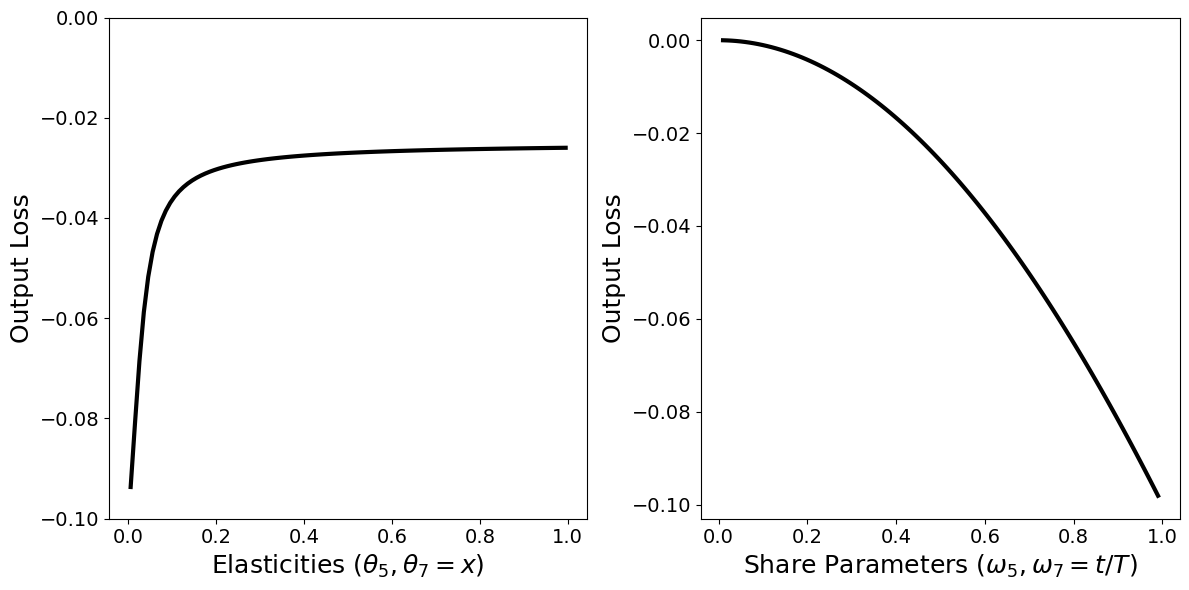

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def labor_from_omegas(omegas, L_tot=1.0):
    omega5, omega6, omega7 = omegas
    L1 = L_tot * omega7 * omega5
    L2 = L_tot * omega7 * (1 - omega5)
    L3 = L_tot * (1 - omega7) * omega6
    L4 = L_tot * (1 - omega7) * (1 - omega6)
    return np.array([L1, L2, L3, L4], dtype=float)

def ces(a, b, omega, theta):
    return ((omega)**(1/theta) * a**((theta - 1)/theta) +
            (1-omega)**(1/theta) * b**((theta - 1)/theta))**(theta/(theta - 1))

def y_stylized_omegaLabor(Zs, omegas, thetas=None, CD=False, return_details=False):
    z1, z2, z3, z4 = Zs
    omega5, omega6, omega7 = omegas

    # labor pinned by omegas; DOES NOT move with z-shocks
    L1, L2, L3, L4 = labor_from_omegas(omegas, L_tot=1.0)

    # primitives (linear in labor)
    x1 = z1 * L1
    x2 = z2 * L2
    x3 = z3 * L3
    x4 = z4 * L4

    # two-level aggregation
    if CD:
        y5 = x1**omega5 * x2**(1 - omega5)
        y6 = x3**omega6 * x4**(1 - omega6)
        y7 = y5**omega7 * y6**(1 - omega7)
    else:
        theta5, theta6, theta7 = thetas
        y5 = ces(x1, x2, omega5, theta5)
        y6 = ces(x3, x4, omega6, theta6)
        y7 = ces(y5, y6, omega7, theta7)

    if return_details:
        return y7, {"L": (L1, L2, L3, L4), "x": (x1, x2, x3, x4)}
    return y7

# ---------- Vary elasticities (omegas fixed) ----------

theta5_list = np.linspace(5e-3, 1 - 5e-3, 100)
output_list_theta = []
for theta in theta5_list:
    omegas = (0.5, 0.5, 0.5)  # omegas fixed in this loop
    theta5 = theta
    theta7 = theta5
    theta6 = 3 - theta5 - theta7  # keep your original relation
    thetas = (theta5, theta6, theta7)
    y_noshock = y_stylized_omegaLabor((1, 1, 1, 1), omegas, thetas, CD=False)
    y_shock  = y_stylized_omegaLabor((.9, 1, 1, 1), omegas, thetas, CD=False)
    output_list_theta.append((y_shock - y_noshock) / y_noshock)

# ---------- Vary omegas (elasticity fixed, Cobb-Douglas) ----------

omega_list = np.linspace(1e-2, 1 - 1e-2, 100)
output_list_omega = []
for omega in omega_list:
    omegas = (omega, 0.5, omega)
    y_noshock = y_stylized_omegaLabor((1, 1, 1, 1), omegas, None, CD=True)
    y_shock  = y_stylized_omegaLabor((.9, 1, 1, 1), omegas, None, CD=True)
    output_list_omega.append((y_shock - y_noshock) / y_noshock)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(theta5_list, output_list_theta, label='Stylized Model Output', color='black', linewidth=3)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel('Elasticities ($\\theta_5, \\theta_7 = x$)', fontsize=18)
ax1.set_ylim(-0.1, 0)
ax1.set_ylabel('Output Loss', fontsize=18)

ax2.plot(omega_list, output_list_omega, label='Stylized Model Output', color='black', linewidth=3)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Share Parameters ($\\omega_5, \\omega_7 = t/T$)', fontsize=18)
ax2.set_ylabel('Output Loss', fontsize=18)

plt.tight_layout()
plt.savefig('../../figures/theory/stylized_model_combined.pdf', bbox_inches='tight', dpi=300)


Draw binary tree digraph.

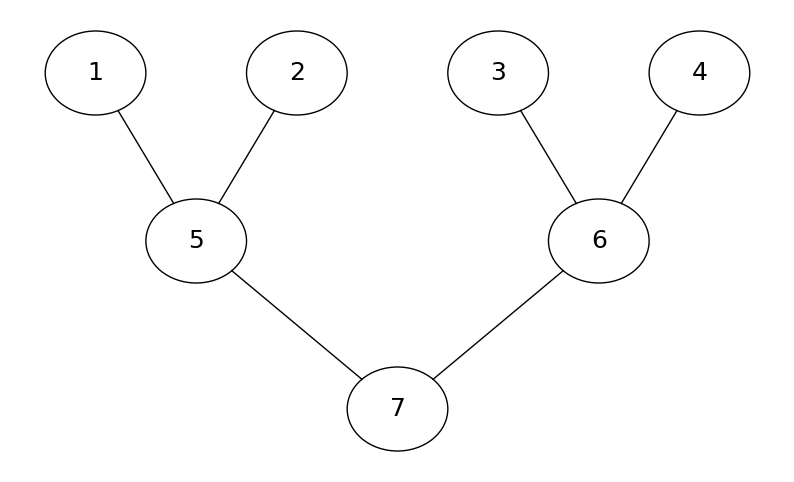

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Define node positions for a flipped binary tree of depth 2
nodes = {
    7: (0, -2),          # Root
    5: (-1, -1), 6: (1, -1),  # Depth 1
    1: (-1.5, 0), 2: (-0.5, 0), 3: (0.5, 0), 4: (1.5, 0)  # Depth 2 (leaves)
}

# Define edges for the binary tree
edges = [
    (7, 5), (7, 6),  # Root to Depth 1
    (5, 1), (5, 2), (6, 3), (6, 4)  # Depth 1 to Depth 2
]

# Function to calculate edge endpoints on circle boundaries
def calculate_edge(x1, y1, x2, y2, radius=0.25):
    dx, dy = x2 - x1, y2 - y1
    dist = np.sqrt(dx**2 + dy**2)
    x1_new = x1 + radius * dx / dist
    y1_new = y1 + radius * dy / dist
    x2_new = x2 - radius * dx / dist
    y2_new = y2 - radius * dy / dist
    return x1_new, y1_new, x2_new, y2_new

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Draw edges
for start, end in edges:
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    x1_new, y1_new, x2_new, y2_new = calculate_edge(x1, y1, x2, y2)
    ax.plot([x1_new, x2_new], [y1_new, y2_new], 'k-', linewidth=1)

# Draw nodes
for label, (x, y) in nodes.items():
    circle = plt.Circle((x, y), 0.25, fill=True, edgecolor='black', facecolor='white')
    ax.add_patch(circle)
    ax.text(x, y, str(label), ha='center', va='center', fontsize=18)

# Save plot
plt.savefig('../../figures/theory/binarytree.pdf', bbox_inches='tight', dpi=300)


Draw alternative binary tree digraph.

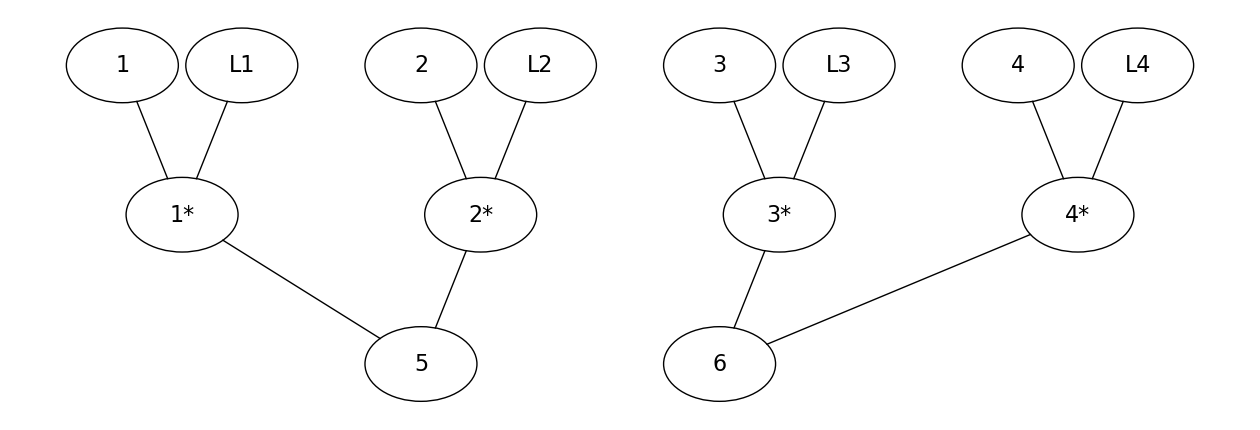

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

# Function to compute edge endpoints on ellipse boundaries
def ellipse_edge(start, end, width, height):
    x1, y1 = nodes[start]
    x2, y2 = nodes[end]
    dx, dy = x2 - x1, y2 - y1
    a, b = width / 2, height / 2
    A = (dx**2) / a**2 + (dy**2) / b**2
    t = 1 / np.sqrt(A)
    p1 = (x1 + t * dx, y1 + t * dy)
    p2 = (x2 - t * dx, y2 - t * dy)
    return p1, p2

# Define node positions with the new indexing
nodes = {
    "1": (-3, 3.0), "L1": (-2.2, 3.0),  # Top row
    "2": (-1, 3.0), "L2": (-0.2, 3.0),
    "3": (1, 3.0), "L3": (1.8, 3.0),
    "4": (3, 3.0), "L4": (3.8, 3.0),
    "1*": (-2.6, 2.0), "2*": (-0.6, 2.0),  # Middle row
    "3*": (1.4, 2.0), "4*": (3.4, 2.0),
    "5": (-1, 1.0), "6": (1, 1.0)  # Bottom row
}

# Define edges with the new indexing
edges = [
    ("1", "1*"), ("L1", "1*"), ("1*", "5"),  # Top to middle, middle to bottom
    ("2", "2*"), ("L2", "2*"), ("2*", "5"),
    ("3", "3*"), ("L3", "3*"), ("3*", "6"),
    ("4", "4*"), ("L4", "4*"), ("4*", "6")
]

# Plot with smaller ellipses
width, height = 0.75, 0.5  # Reduced to prevent overlaps
fig, ax = plt.subplots(figsize=(16, 9))
ax.axis('off')
ax.set_aspect('equal')

# Draw edges
for s, e in edges:
    p1, p2 = ellipse_edge(s, e, width, height)
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', linewidth=1)

# Draw nodes as horizontal ovals
for label, (x, y) in nodes.items():
    ellipse = Ellipse((x, y), width, height, fill=False, edgecolor='black')
    ax.add_patch(ellipse)
    fs = 16 if isinstance(label, str) else 16
    ax.text(x, y, str(label), ha='center', va='center', fontsize=fs)

# Save as PDF
plt.savefig("../../figures/theory/binarytree_ext.pdf", bbox_inches='tight', dpi=300)
